In [256]:
# constant
RAW_DATA_CLEANED = "../data/preprocessed/cleaned/marketing_campaign.csv" 
Export_DATA_ENGINEERING = "../data/preprocessed/engineering/marketing_campaign.csv" 

In [257]:
import pandas as pd
import numpy as np 
from scipy import stats
import matplotlib.pyplot as plt


from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline



from sklearn.preprocessing import StandardScaler, MinMaxScaler


# set the max columns to none
pd.set_option('display.max_columns', None)

In [258]:
data = pd.read_parquet(RAW_DATA_CLEANED)
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1
1,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0
2,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0
3,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0
4,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0


### Education and Marital_Status


In [259]:
## Education and Marital_Status
# Education	Marital_Status with many destinct values
# (decision) what will we do with them ?
data.Marital_Status.value_counts()
# after understandig the situation of every one 
# merge YOLO, Absurd, Alone in single and let other



Marital_Status
Married     854
Together    568
Single      470
Divorced    230
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64

In [260]:
status_map = {
    'Alone': 'Single',
    'Absurd': 'Single',
    'YOLO': 'Single'
}

data.Marital_Status = data.Marital_Status.replace(status_map)
data.Marital_Status.value_counts()

/tmp/ipykernel_4967/3411124049.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  data.Marital_Status = data.Marital_Status.replace(status_map)


Marital_Status
Married     854
Together    568
Single      477
Divorced    230
Widow        76
Name: count, dtype: int64

In [261]:
# education 
data.Education.value_counts() # i think no action needed

Education
Graduation    1113
PhD            476
Master         364
2n Cycle       198
Basic           54
Name: count, dtype: int64

## Detecting and handling outliers

Strategies:
 - Demographics features: drop them (in clean part)
 - other numeric features like MntFruits and Recency:
    - transformation and scaling.
    - the next step depend on the task or the question that we want to answer from the data.


> IMPORTANT NOTE: the stratege that we will use later is depend on the task or the question we want to answer.

> NOTE: here, we only care about detecting and try to decrease the impact of outliers. 

- univarite

In [262]:
# Demographics features

# univarite
Demographics_cols = ['Year_Birth', 'Income']

Q1 = data[Demographics_cols].quantile(0.25)
Q3 = data[Demographics_cols].quantile(0.75)
IQR = Q3 - Q1

before = data.shape[0]
data = data[~((data[Demographics_cols] < (Q1 - 1.5 * IQR)) | (data[Demographics_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
after = data.shape[0]
dropped = before - after
print(f" len droped rows {before - after}, percentage = {format((dropped / before),'.3f')}%")


 len droped rows 0, percentage = 0.000%


In [263]:
# univarite
numerical_cols = ['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

Q1 = data[numerical_cols].quantile(0.25)
Q3 = data[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# only very extreme values
thr = 1.5

((data[numerical_cols] < (Q1 - thr * IQR)) | (data[numerical_cols] > (Q3 + thr * IQR))).sum(axis=0)

Recency                  0
MntWines                34
MntFruits              245
MntMeatProducts        170
MntFishProducts        222
MntSweetProducts       238
MntGoldProds           204
NumDealsPurchases       82
NumWebPurchases          3
NumCatalogPurchases     20
NumStorePurchases        0
NumWebVisitsMonth        8
dtype: int64

In [264]:
# in every one
((data[numerical_cols] < (Q1 - thr * IQR)) | (data[numerical_cols] > (Q3 + thr * IQR))).sum(axis=0).sum()

1226

In [265]:
# if row has more than one true, will be catched only one time.
((data[numerical_cols] < (Q1 - thr * IQR)) | (data[numerical_cols] > (Q3 + thr * IQR))).any(axis=1).sum(axis=0)

696

- multivariate
    - Isolation Forest and LocalOutlierFactor : need strong domine knowledge with strong info about the process that the data was faced, to determine the contamination.
    - DBSCAN : to detect outliers in multivariate (may be just a cluster not an outliers)

In [266]:
df = data.copy()

In [267]:
# DBSCAN

# Prepare the data
X = df[numerical_cols]

# Standardize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Function to find optimal epsilon
def find_epsilon(X, n_neighbors=5):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return np.percentile(distances, 90)

# Find optimal epsilon
epsilon = find_epsilon(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=5)
cluster_labels = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the dataframe
df['cluster'] = cluster_labels

# Identify outliers (points labeled as -1 are considered noise/outliers)
df['is_outlier'] = (cluster_labels == -1).astype(int)

# Separate inliers and outliers
df_inliers = df[df['is_outlier'] == 0].drop(['cluster', 'is_outlier'], axis=1)
df_outliers = df[df['is_outlier'] == 1].drop(['cluster', 'is_outlier'], axis=1)

print(f"Number of outliers detected: {len(df_outliers)}")
print(f"Shape of dataset before removing outliers: {df.shape}")
print(f"Shape of dataset after removing outliers: {df_inliers.shape}")
print(f" percentage = {format((df_outliers.shape[0] / df.shape[0]),'.3f')}%")

Number of outliers detected: 360
Shape of dataset before removing outliers: (2205, 28)
Shape of dataset after removing outliers: (1845, 26)
 percentage = 0.163%


### distributions transformations (normalization).

In [268]:
# Define the transformations 
log_transformer = FunctionTransformer(np.log1p, validate=True)
robust_scaler = RobustScaler()
zscore_scaler = StandardScaler()
minMax = MinMaxScaler()

In [269]:
# Define the features for each transformation
log_features = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts',
                'MntSweetProducts', 'MntGoldProds','NumDealsPurchases', 'NumWebPurchases',
                'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5'] is a category features

In [270]:
# Create a ColumnTransformer to apply the transformations
# Combine log transformation and scaling in one ColumnTransformer
combined_transformer = ColumnTransformer(
    transformers=[
        ('log_and_scale', Pipeline([
            ('log', log_transformer),
 #           ('scaler', zscore_scaler)
        ]), log_features),
    ],
    remainder='passthrough'  # Leave other columns unchanged
)

# Apply the combined transformation to the dataset
data_transformed = combined_transformer.fit_transform(data)

# Convert the result back to a DataFrame for better readability
transformed_columns = log_features  
remaining_columns = [col for col in data.columns if col not in transformed_columns]
all_columns = transformed_columns + remaining_columns

data_transformed_df = pd.DataFrame(data_transformed, columns=all_columns)

# Display the first few rows of the transformed data
data_transformed_df.head()


,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,2.197225,2.397895,1.609438,2.079442,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,0,0,0,0,0,0,1
1,2.484907,0.693147,1.94591,1.098612,0.693147,1.94591,1.098612,0.693147,0.693147,1.098612,1.791759,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,0,0,0,0,0,0,0
2,6.056784,3.912023,4.85203,4.718499,3.091042,3.7612,0.693147,2.197225,1.098612,2.397895,1.609438,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,0,0,0,0,0,0,0
3,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,1.098612,0.0,1.609438,1.94591,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,0,0,0,0,0,0,0
4,5.159055,3.78419,4.779123,3.850148,3.332205,2.772589,1.791759,1.791759,1.386294,1.94591,1.791759,1981,PhD,Married,58293.0,1,0,2014-01-19,94,0,0,0,0,0,0,0


In [271]:
# convert types
for col in remaining_columns:
    data_transformed_df[col] = data_transformed_df[col].astype(data[col].dtype)

for col in transformed_columns:
    data_transformed_df[col] = data_transformed_df[col].astype(float)

data_transformed_df.dtypes

MntWines                      float64
MntFruits                     float64
MntMeatProducts               float64
MntFishProducts               float64
MntSweetProducts              float64
MntGoldProds                  float64
NumDealsPurchases             float64
NumWebPurchases               float64
NumCatalogPurchases           float64
NumStorePurchases             float64
NumWebVisitsMonth             float64
Year_Birth                      int64
Education                    category
Marital_Status               category
Income                        float64
Kidhome                         int64
Teenhome                        int64
Dt_Customer            datetime64[ns]
Recency                         int64
AcceptedCmp3                    int64
AcceptedCmp4                    int64
AcceptedCmp5                    int64
AcceptedCmp1                    int64
AcceptedCmp2                    int64
Complain                        int64
Response                        int64
dtype: objec

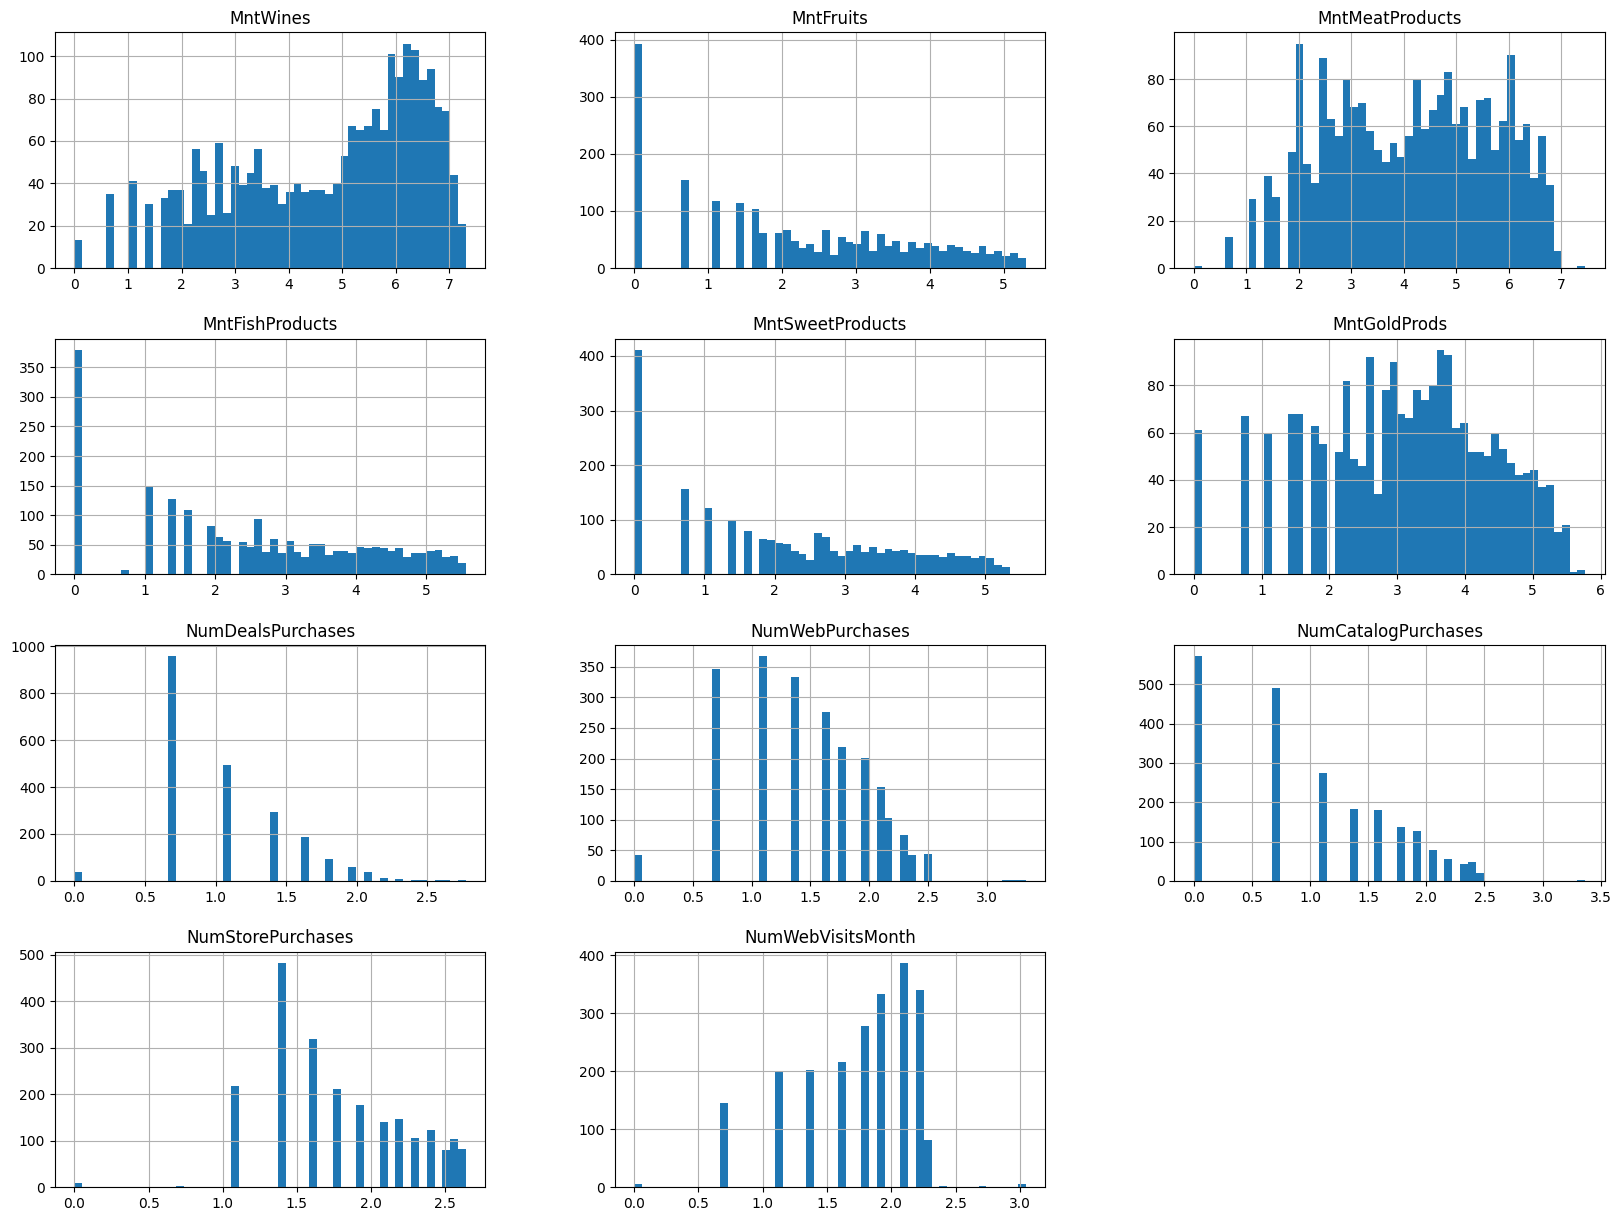

In [272]:
data_transformed_df[transformed_columns].hist(bins=50, figsize=(20, 15))
plt.show()

In [273]:
# copy the data

df = data_transformed_df.copy()

In [274]:
# univarite
numerical_cols = ['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds','NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

Q1 = df[numerical_cols].quantile(0.25)
Q3 = df[numerical_cols].quantile(0.75)
IQR = Q3 - Q1

# only very extreme values
thr = 1.5

((df[numerical_cols] < (Q1 - thr * IQR)) | (df[numerical_cols] > (Q3 + thr * IQR))).sum(axis=0)

Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases      16
NumWebPurchases         2
NumCatalogPurchases     0
NumStorePurchases      10
NumWebVisitsMonth       6
dtype: int64

In [275]:
# DBSCAN


# Prepare the data
X = df[numerical_cols]

# Standardize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


# Function to find optimal epsilon
def find_epsilon(X, n_neighbors=5):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(X)
    distances, indices = nbrs.kneighbors(X)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    return np.percentile(distances, 90)

# Find optimal epsilon
epsilon = find_epsilon(X_scaled)

# Apply DBSCAN
dbscan = DBSCAN(eps=epsilon, min_samples=5)
cluster_labels = dbscan.fit_predict(X_scaled)

# Add the cluster labels to the dataframe
df['cluster'] = cluster_labels

# Identify outliers (points labeled as -1 are considered noise/outliers)
df['is_outlier'] = (cluster_labels == -1).astype(int)

# Separate inliers and outliers
df_inliers = df[df['is_outlier'] == 0].drop(['cluster', 'is_outlier'], axis=1)
df_outliers = df[df['is_outlier'] == 1].drop(['cluster', 'is_outlier'], axis=1)

print(f"Number of outliers detected: {len(df_outliers)}")
print(f"Shape of dataset before removing outliers: {df.shape}")
print(f"Shape of dataset after removing outliers: {df_inliers.shape}")
print(f" percentage = {format((df_outliers.shape[0] / df.shape[0]),'.3f')}%")

Number of outliers detected: 391
Shape of dataset before removing outliers: (2205, 28)
Shape of dataset after removing outliers: (1814, 26)
 percentage = 0.177%


###  a look at the data and fast clustering in 2d

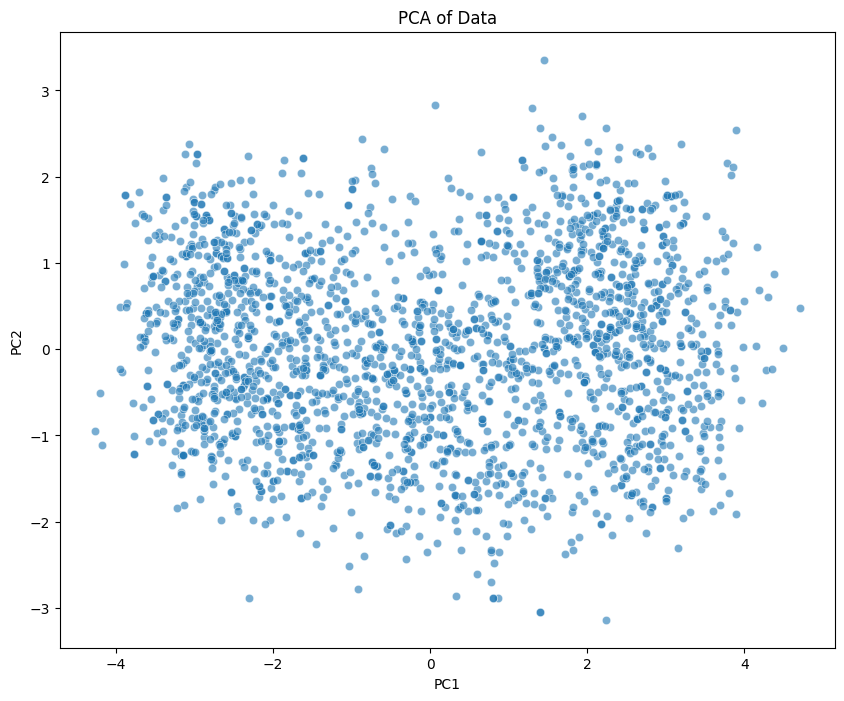

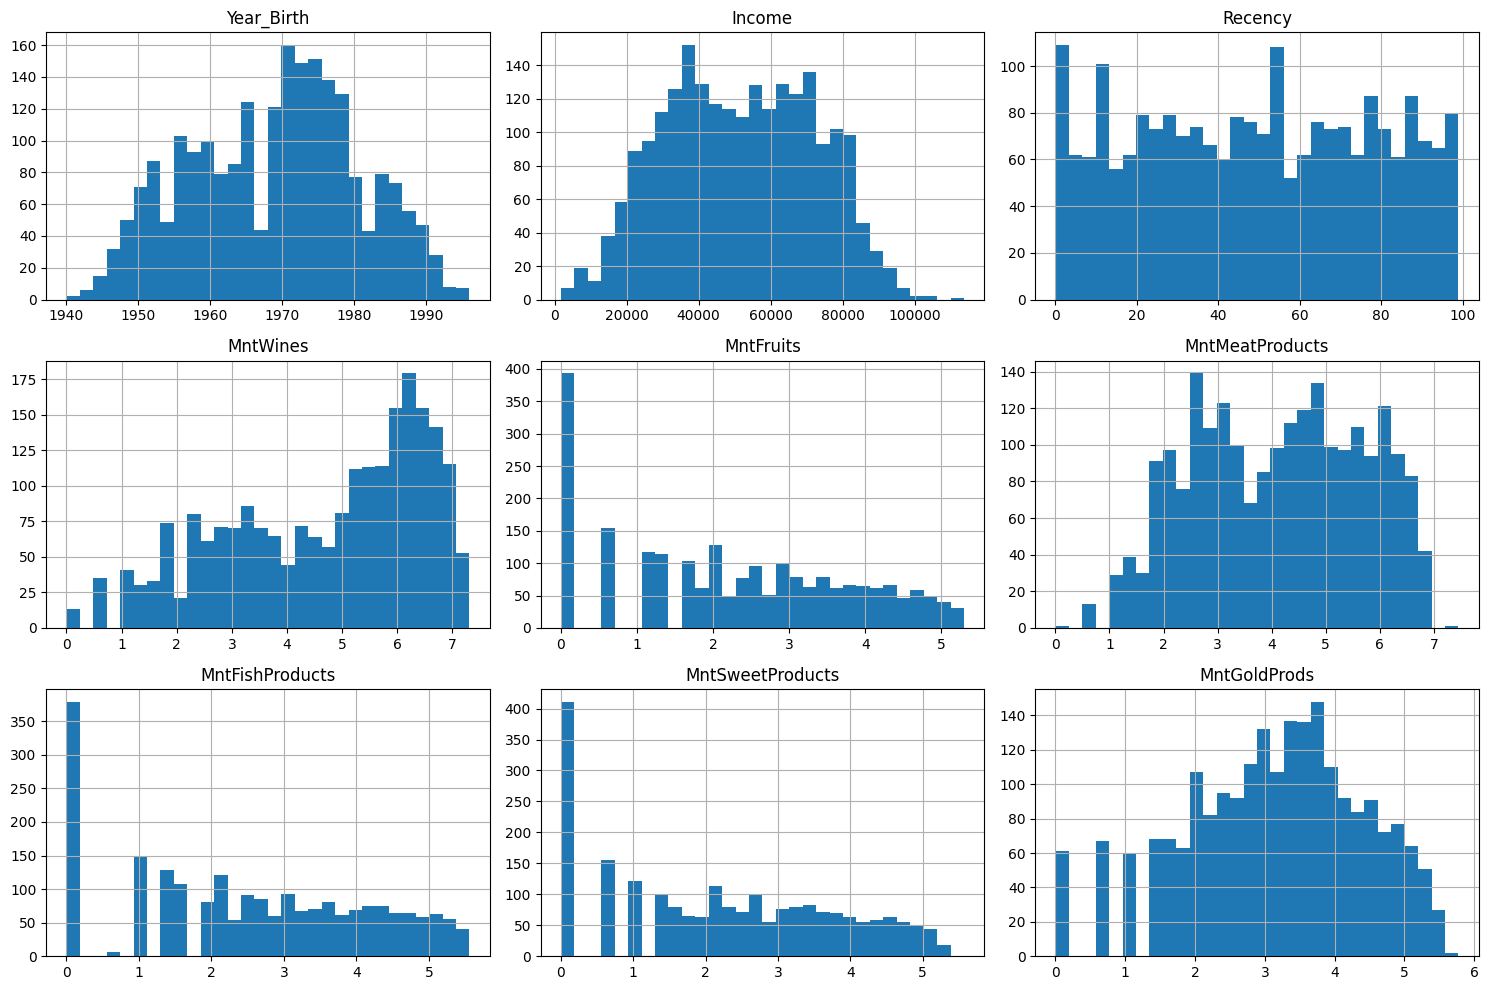

        Year_Birth         Income      Recency     MntWines    MntFruits  \
count  2205.000000    2205.000000  2205.000000  2205.000000  2205.000000   
mean   1968.904308   51622.094785    49.009070     4.686567     2.247012   
std      11.705801   20713.063826    28.932111     1.801605     1.569506   
min    1940.000000    1730.000000     0.000000     0.000000     0.000000   
1%     1945.040000    7521.120000     0.000000     0.693147     0.000000   
5%     1950.000000   18980.000000     4.000000     1.386294     0.000000   
25%    1959.000000   35196.000000    24.000000     3.218876     1.098612   
50%    1970.000000   51287.000000    49.000000     5.187386     2.197225   
75%    1977.000000   68281.000000    74.000000     6.230481     3.526361   
95%    1988.000000   83829.000000    94.000000     6.909554     4.812184   
99%    1992.000000   92846.880000    98.000000     7.159292     5.153292   
max    1996.000000  113734.000000    99.000000     7.309212     5.298317   

       MntM

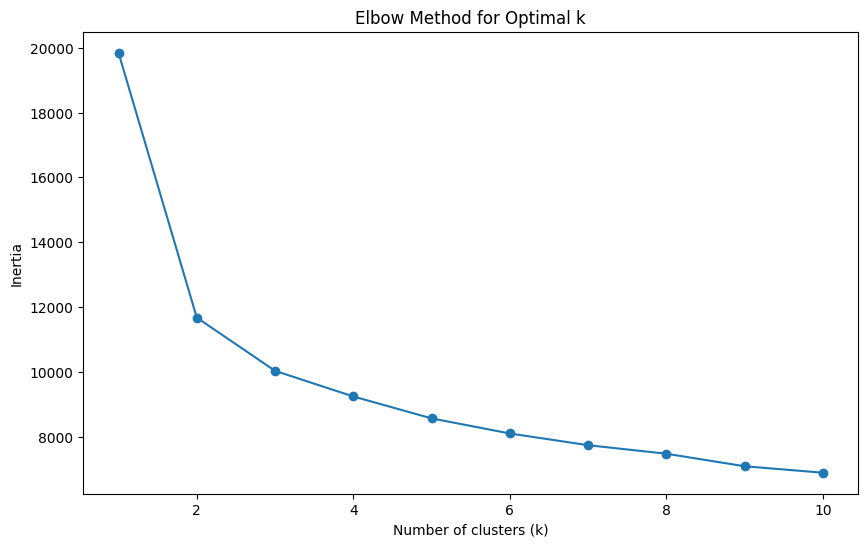

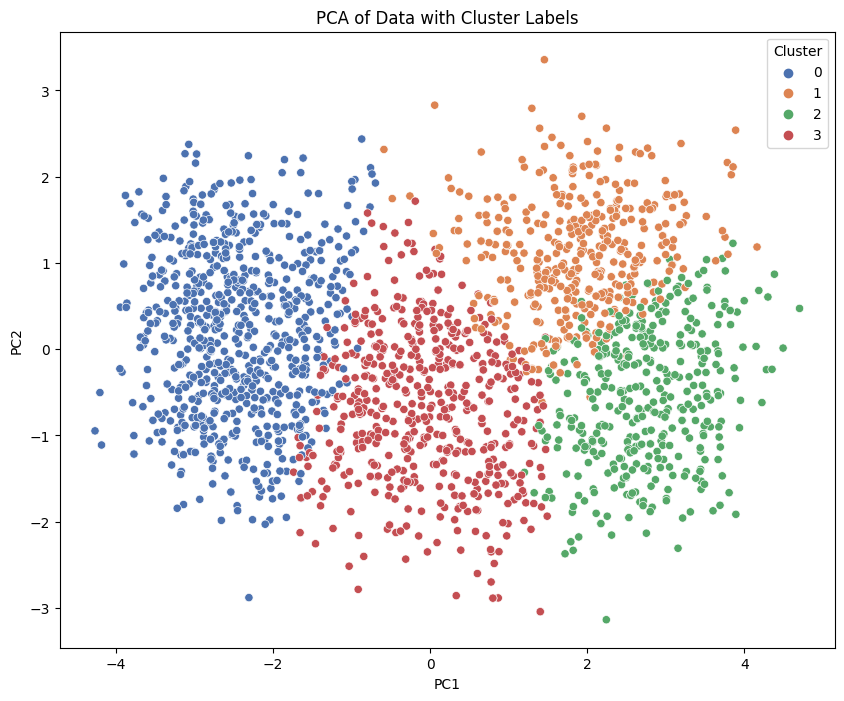

In [276]:
import seaborn as sns
from sklearn.decomposition import PCA

# Assuming 'df' is your DataFrame and 'numerical_cols' is defined as before
numerical_cols = ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[numerical_cols])

# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])

# Plot the PCA results
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', alpha=0.6)
plt.title('PCA of Data')
plt.show()

# Plot histograms of each feature
df[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

# Calculate and print summary statistics
summary_stats = df[numerical_cols].describe(percentiles=[.01, .05, .25, .5, .75, .95, .99])
print(summary_stats)

# Identify potential subgroups or clusters
from sklearn.cluster import KMeans

# Elbow method to find optimal number of clusters
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the PCA plot
pca_df['Cluster'] = cluster_labels
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='deep')
plt.title('PCA of Data with Cluster Labels')
plt.show()

### add features

In [277]:
data_transformed_df

,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
0,6.455199,4.488636,6.304449,5.153292,4.488636,4.488636,1.386294,2.197225,2.397895,1.609438,2.079442,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,0,0,0,0,0,0,1
1,2.484907,0.693147,1.945910,1.098612,0.693147,1.945910,1.098612,0.693147,0.693147,1.098612,1.791759,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,0,0,0,0,0,0,0
2,6.056784,3.912023,4.852030,4.718499,3.091042,3.761200,0.693147,2.197225,1.098612,2.397895,1.609438,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,0,0,0,0,0,0,0
3,2.484907,1.609438,3.044522,2.397895,1.386294,1.791759,1.098612,1.098612,0.000000,1.609438,1.945910,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,0,0,0,0,0,0,0
4,5.159055,3.784190,4.779123,3.850148,3.332205,2.772589,1.791759,1.791759,1.386294,1.945910,1.791759,1981,PhD,Married,58293.0,1,0,2014-01-19,94,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,6.565265,3.784190,5.209486,3.761200,4.779123,5.513429,1.098612,2.302585,1.386294,1.609438,1.791759,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,0,0,0,0,0,0,0
2201,6.008813,0.000000,3.433987,0.000000,0.000000,2.197225,2.079442,2.197225,1.098612,1.791759,2.079442,1946,PhD,Together,64014.0,2,1,2014-06-10,56,0,0,0,1,0,0,0
2202,6.812345,3.891820,5.384495,3.496508,2.564949,3.218876,0.693147,1.098612,1.386294,2.639057,1.945910,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,0,1,0,0,0,0,0
2203,6.061457,3.433987,5.370638,4.394449,3.433987,4.127134,1.098612,1.945910,1.791759,2.397895,1.386294,1956,Master,Together,69245.0,0,1,2014-01-24,8,0,0,0,0,0,0,0


In [278]:
# save the dataframe
data.to_csv(Export_DATA_PATH)

NameError: name 'Export_DATA_PATH' is not defined